# 64-D image manifold: images

In [1]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import torch

sys.path.append("../../")
from experiments.datasets import FFHQStyleGAN64DLoader
from experiments.architectures.image_transforms import create_image_transform, create_image_encoder
from experiments.architectures.vector_transforms import create_vector_transform
from manifold_flow.flows import ManifoldFlow, EncoderManifoldFlow
import plot_settings as ps


In [2]:
ps.setup()

## Helper function to go from torch to numpy conventions

In [3]:
def trf(x):
    return np.clip(np.transpose(x, [1,2,0]) / 256., 0., 1.)

## Load models

In [4]:
def load_model(
    filename,
    outerlayers=20,
    innerlayers=8,
    levels=4,
    splinebins=11,
    splinerange=10.0,
    dropout=0.0,
    actnorm=True,
    batchnorm=False,
    linlayers=2,
    linchannelfactor=2,
    lineartransform="lu"
):
    steps_per_level = outerlayers // levels
    spline_params = {
        "apply_unconditional_transform": False,
        "min_bin_height": 0.001,
        "min_bin_width": 0.001,
        "min_derivative": 0.001,
        "num_bins": splinebins,
        "tail_bound": splinerange,
    }
    outer_transform = create_image_transform(
        3,
        64,
        64,
        levels=levels,
        hidden_channels=100,
        steps_per_level=steps_per_level,
        num_res_blocks=2,
        alpha=0.05,
        num_bits=8,
        preprocessing="glow",
        dropout_prob=dropout,
        multi_scale=True,
        spline_params=spline_params,
        postprocessing="partial_mlp",
        postprocessing_layers=linlayers,
        postprocessing_channel_factor=linchannelfactor,
        use_actnorm=actnorm,
        use_batchnorm=batchnorm,
    )
    inner_transform = create_vector_transform(
        64,
        innerlayers,
        linear_transform_type=lineartransform,
        base_transform_type="rq-coupling",
        context_features=1,
        dropout_probability=dropout,
        tail_bound=splinerange,
        num_bins=splinebins,
        use_batch_norm=batchnorm,
    )
    model = ManifoldFlow(
        data_dim=(3, 64, 64),
        latent_dim=64,
        outer_transform=outer_transform,
        inner_transform=inner_transform,
        apply_context_to_outer=False,
        pie_epsilon=0.1,
        clip_pie=None
    )
        
    model.load_state_dict(
        torch.load("../data/models/{}.pt".format(filename), map_location=torch.device("cpu"))
    )
    _ = model.eval()
    
    return model

In [5]:
def load_emf_model(
    filename,
    outerlayers=20,
    innerlayers=8,
    levels=4,
    splinebins=11,
    splinerange=10.0,
    dropout=0.0,
    actnorm=True,
    batchnorm=False,
    linlayers=2,
    linchannelfactor=2,
    lineartransform="lu"
):
    steps_per_level = outerlayers // levels
    spline_params = {
        "apply_unconditional_transform": False,
        "min_bin_height": 0.001,
        "min_bin_width": 0.001,
        "min_derivative": 0.001,
        "num_bins": splinebins,
        "tail_bound": splinerange,
    }
    encoder = create_image_encoder(
        3,
        64,
        64,
        latent_dim=64,
        context_features=None,
    )
    outer_transform = create_image_transform(
        3,
        64,
        64,
        levels=levels,
        hidden_channels=100,
        steps_per_level=steps_per_level,
        num_res_blocks=2,
        alpha=0.05,
        num_bits=8,
        preprocessing="glow",
        dropout_prob=dropout,
        multi_scale=True,
        spline_params=spline_params,
        postprocessing="partial_mlp",
        postprocessing_layers=linlayers,
        postprocessing_channel_factor=linchannelfactor,
        use_actnorm=actnorm,
        use_batchnorm=batchnorm,
    )
    inner_transform = create_vector_transform(
        64,
        innerlayers,
        linear_transform_type=lineartransform,
        base_transform_type="rq-coupling",
        context_features=1,
        dropout_probability=dropout,
        tail_bound=splinerange,
        num_bins=splinebins,
        use_batch_norm=batchnorm,
    )
    model = EncoderManifoldFlow(
        data_dim=(3, 64, 64),
        latent_dim=2,
        encoder=encoder,
        outer_transform=outer_transform,
        inner_transform=inner_transform,
        apply_context_to_outer=False,
        pie_epsilon=0.1,
        clip_pie=None
    )
        
    model.load_state_dict(
        torch.load("../data/models/{}.pt".format(filename), map_location=torch.device("cpu"))
    )
    _ = model.eval()
    
    return model

In [6]:
mf = load_model("mf_64_gan64d_april")
emf = load_emf_model("emf_64_gan64d_april")
pie = load_model("pie_64_gan64d_april")

/Users/distiller/project/conda/conda-bld/pytorch_1587428061935/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


## Sample comparison

In [7]:
n = 8

x_test = 0.5 + 255. * np.load("../data/samples/gan64d/x_test_prior.npy")[:n]
x_gen_af = np.load("../data/results/flow_2_gan64d_april_samples.npy")[:n]
x_gen_pie = np.load("../data/results/pie_64_gan64d_april_samples.npy")[:n]
x_gen_mf = np.load("../data/results/mf_64_gan64d_april_samples.npy")[:n]
x_gen_emf = np.load("../data/results/emf_64_gan64d_april_samples.npy")[:n]


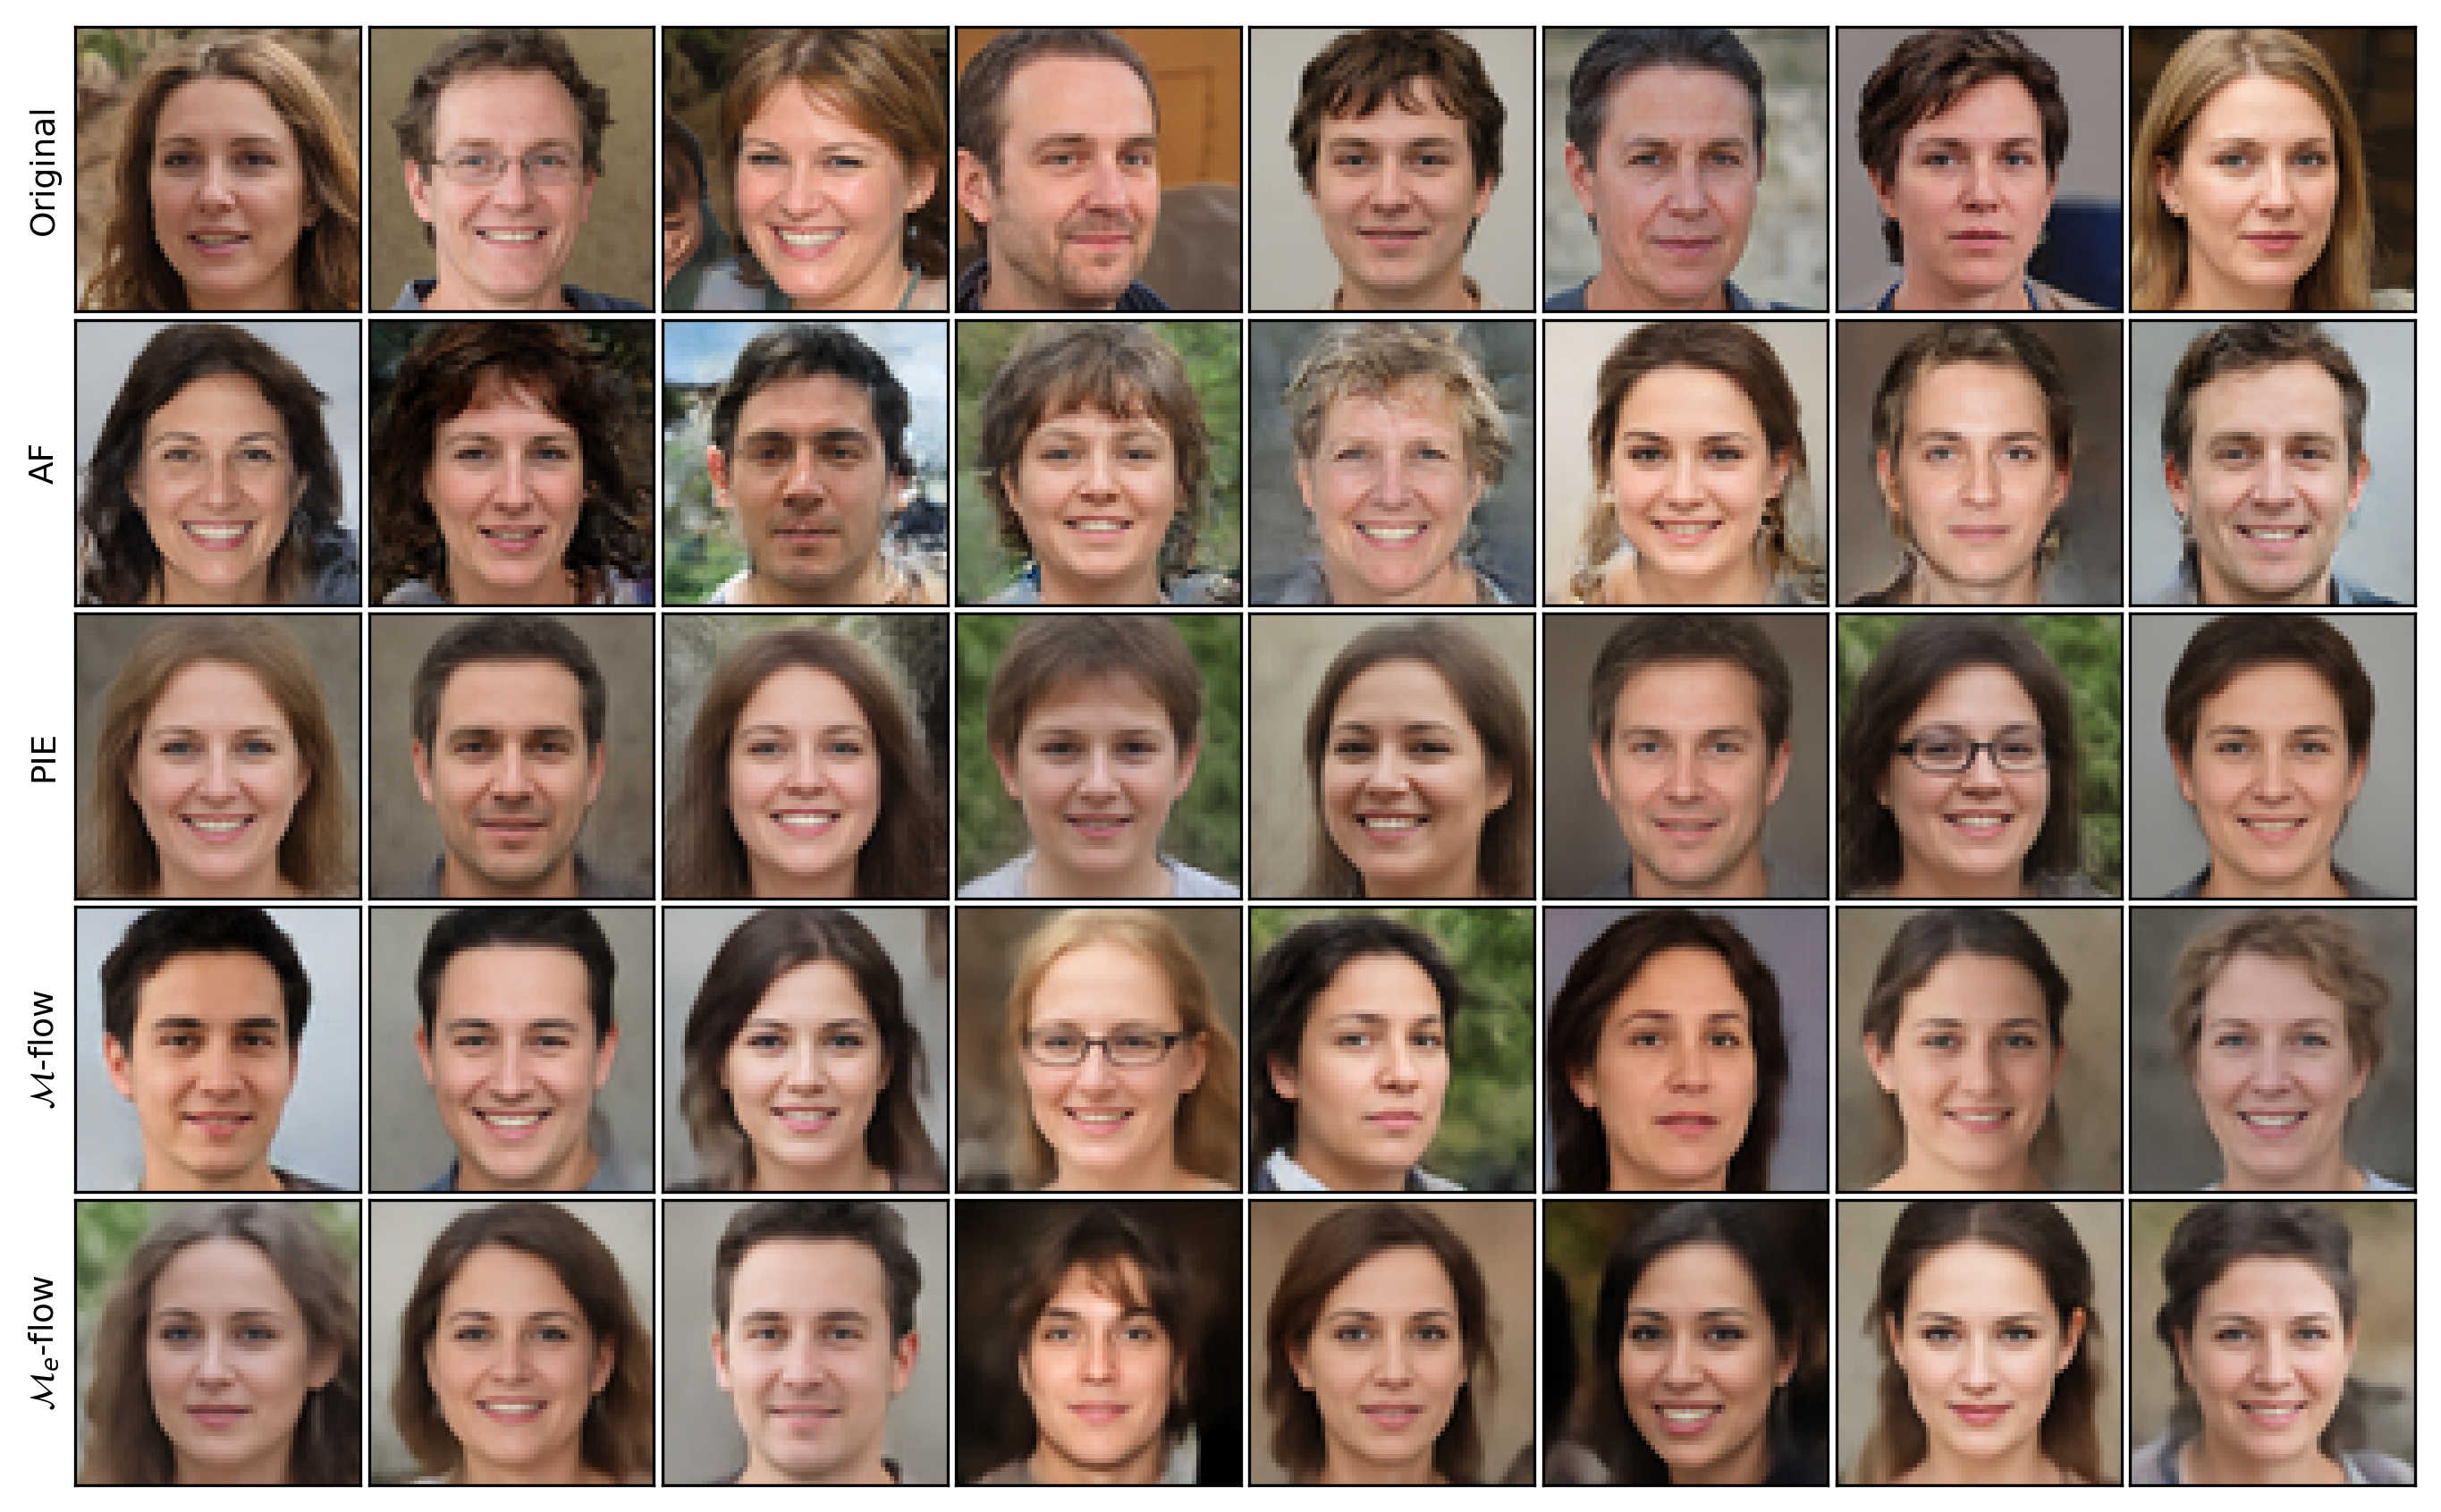

In [8]:
nrows = 5
ncols = 8

xs = [x_test, x_gen_af, x_gen_pie, x_gen_mf, x_gen_emf]
labels = ["Original", "AF", r"PIE", r"$\mathcal{M}$-flow", r"$\mathcal{M}_e$-flow"]

fig, gs = ps.grid_width(ncols, nrows, width=ps.TEXTWIDTH, large_margin=0.04, small_margin=0.01, sep=0.005, t_space=False, b_space=False, r_space=False, l_space=True)

for i in range(ncols):
    for j, (x, label) in enumerate(zip(xs, labels)):
        ax = plt.subplot(gs[j*ncols + i])
        plt.imshow(trf(x[i]))
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        if i == 0:
            plt.ylabel(label)
    
plt.savefig("../figures/gan64d_samples.pdf")


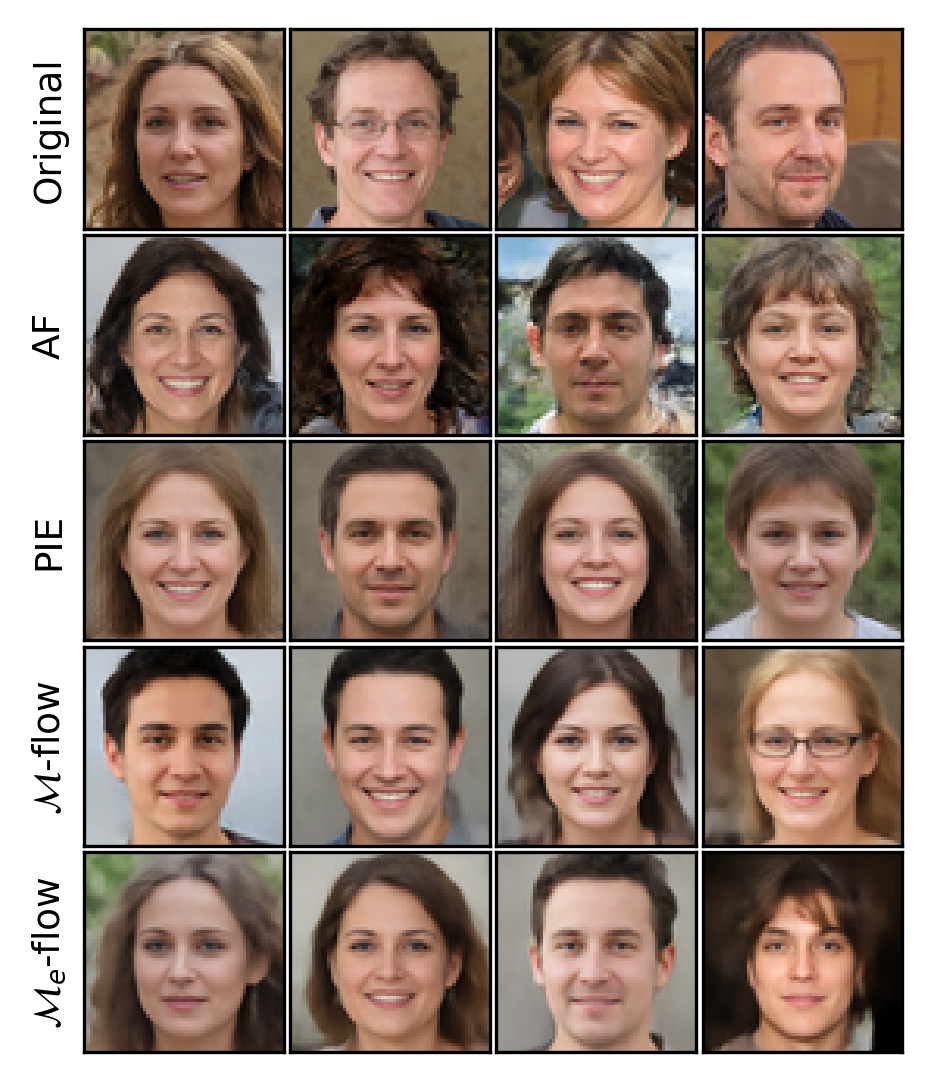

In [9]:
nrows = 5
ncols = 4

xs = [x_test, x_gen_af, x_gen_pie, x_gen_mf, x_gen_emf]
labels = ["Original", "AF", r"PIE", r"$\mathcal{M}$-flow", r"$\mathcal{M}_e$-flow"]

fig, gs = ps.grid_width(ncols, nrows, width=0.33 * ps.TEXTWIDTH, large_margin=0.06, small_margin=0.01, sep=0.005, t_space=False, b_space=False, r_space=False, l_space=True)

for i in range(ncols):
    for j, (x, label) in enumerate(zip(xs, labels)):
        ax = plt.subplot(gs[j*ncols + i])
        plt.imshow(trf(x[i]))
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        if i == 0:
            plt.ylabel(label)
    
plt.savefig("../figures/gan64d_samples_small.pdf")


## Test samples and projections to learned manifolds

In [10]:
test_idx=list(range(8))
n_test = len(test_idx)

x_test = 0.5 + 255. * np.load("../data/samples/gan64d/x_test.npy")[test_idx]
x_reco_mf = np.load("../data/results/mf_64_gan64d_april_model_x_reco_test.npy")[test_idx]
x_reco_emf = np.load("../data/results/emf_64_gan64d_april_model_x_reco_test.npy")[test_idx]
x_reco_pie = np.load("../data/results/pie_64_gan64d_april_model_x_reco_test.npy")[test_idx]


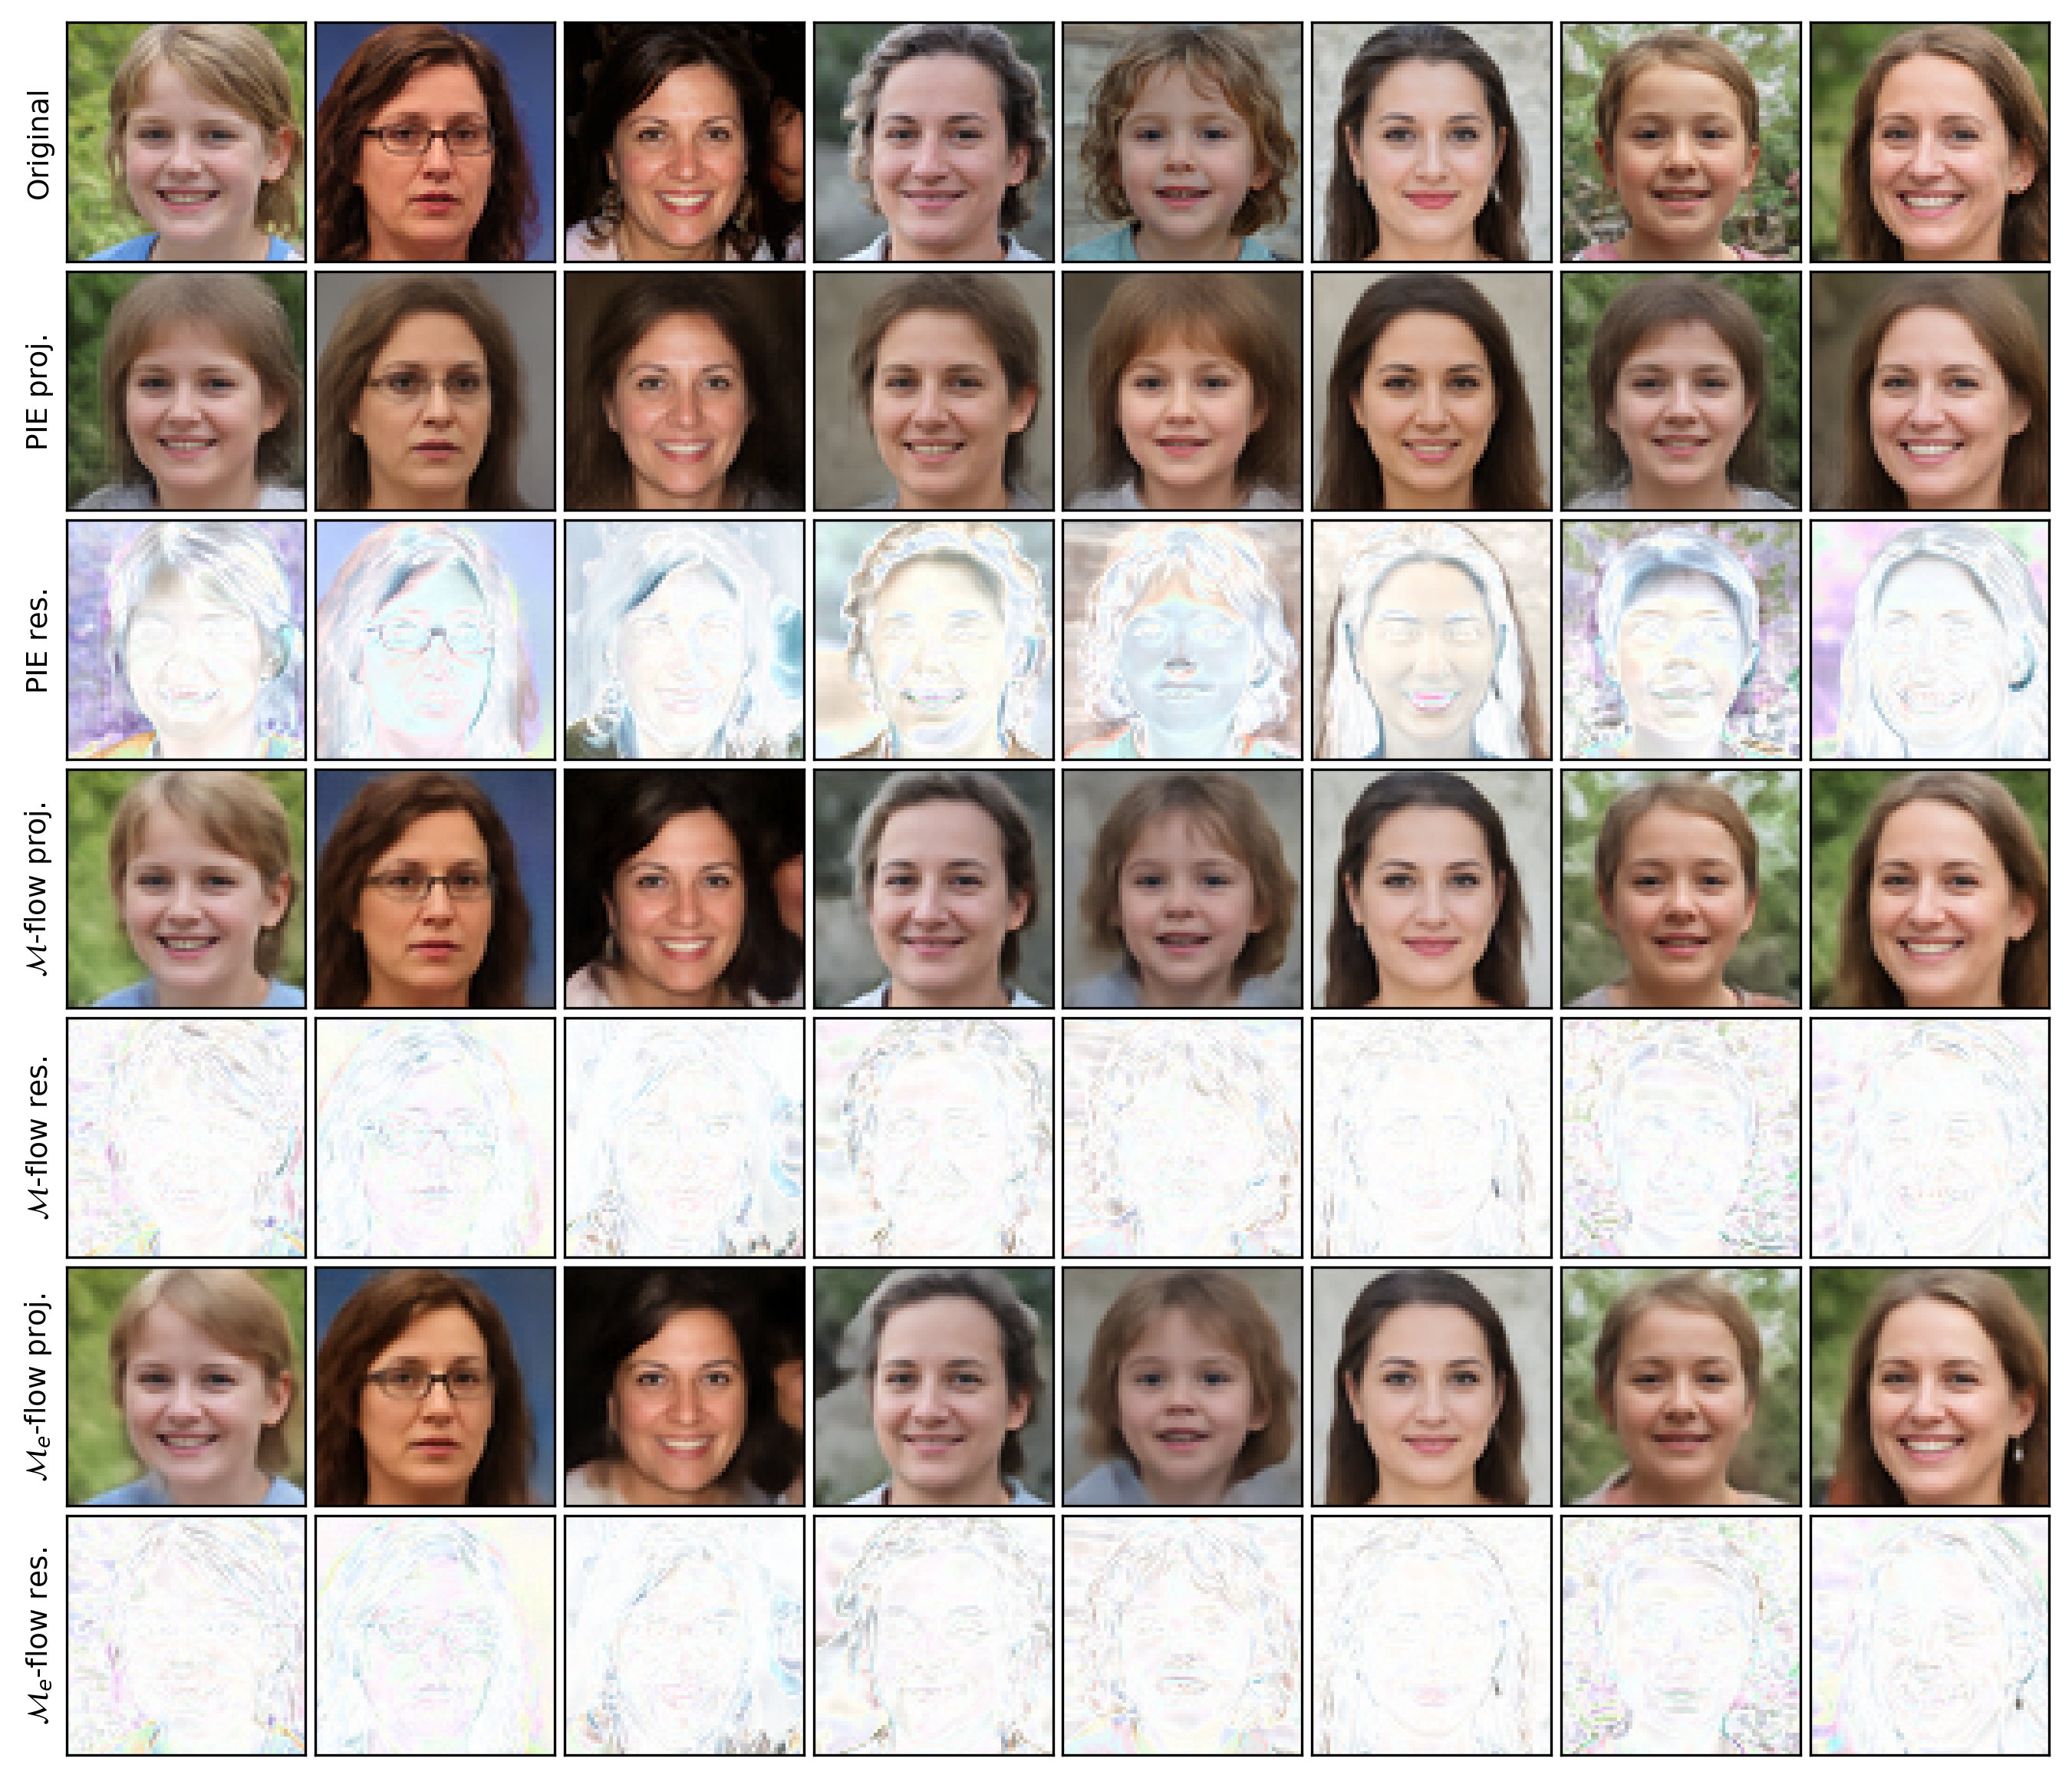

In [11]:
nrows = 7
enhance = 1
labels = ["Original", "PIE proj.", "PIE res.", "$\mathcal{M}$-flow proj.", r"$\mathcal{M}$-flow res.", "$\mathcal{M}_e$-flow proj.", "$\mathcal{M}_e$-flow res."]

fig, gs = ps.grid_width(n_test, nrows, width=ps.TEXTWIDTH, large_margin=0.04, small_margin=0.01, sep=0.005, t_space=False, b_space=False, r_space=False, l_space=True)

for i in range(n_test):
    xs = [
        trf(x_test[i]),
        trf(x_reco_pie[i]),
        1. - enhance*np.abs(trf(x_reco_pie[i]) - trf(x_test[i])),
        trf(x_reco_mf[i]),
        1. - enhance*np.abs(trf(x_reco_mf[i]) - trf(x_test[i])),
        trf(x_reco_emf[i]),
        1. - enhance*np.abs(trf(x_reco_emf[i]) - trf(x_test[i]))
    ]
    
    for j, (x, label) in enumerate(zip(xs, labels)):
        ax = plt.subplot(gs[j * n_test + i])
        plt.imshow(x)
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        if i == 0:
            plt.ylabel(label)
    
plt.savefig("../figures/gan64d_projections.pdf")


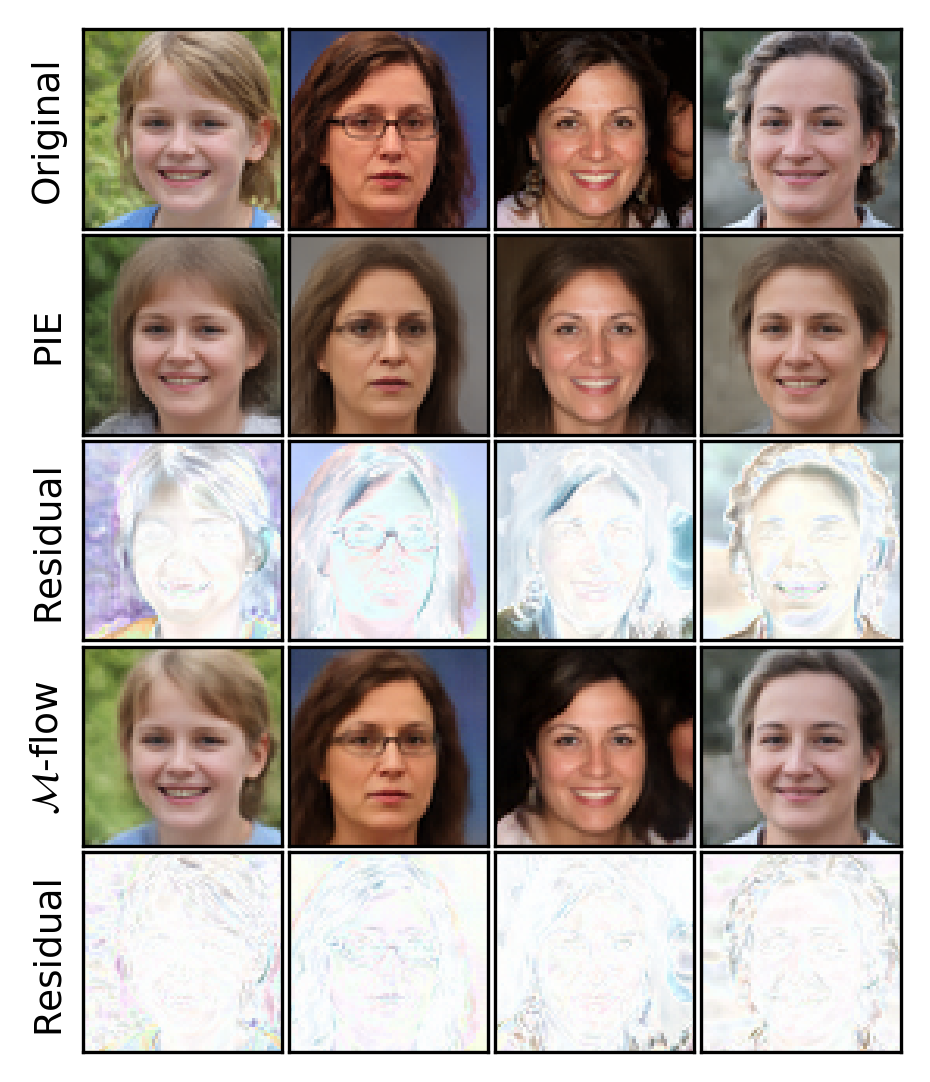

In [12]:
nrows = 5
ncols = 4
enhance = 1
labels = ["Original", "PIE", "Residual", "$\mathcal{M}$-flow", r"Residual"]

fig, gs = ps.grid_width(ncols, nrows, width=0.33 * ps.TEXTWIDTH, large_margin=0.06, small_margin=0.01, sep=0.005, t_space=False, b_space=False, r_space=False, l_space=True)

for i in range(ncols):
    xs = [
        trf(x_test[i]),
        trf(x_reco_pie[i]),
        1. - enhance*np.abs(trf(x_reco_pie[i]) - trf(x_test[i])),
        trf(x_reco_mf[i]),
        1. - enhance*np.abs(trf(x_reco_mf[i]) - trf(x_test[i])),
    ]
    
    for j, (x, label) in enumerate(zip(xs, labels)):
        ax = plt.subplot(gs[j * ncols + i])
        plt.imshow(x)
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        if i == 0:
            plt.ylabel(label)
    
plt.savefig("../figures/gan64d_projections_small.pdf")


## Training samples

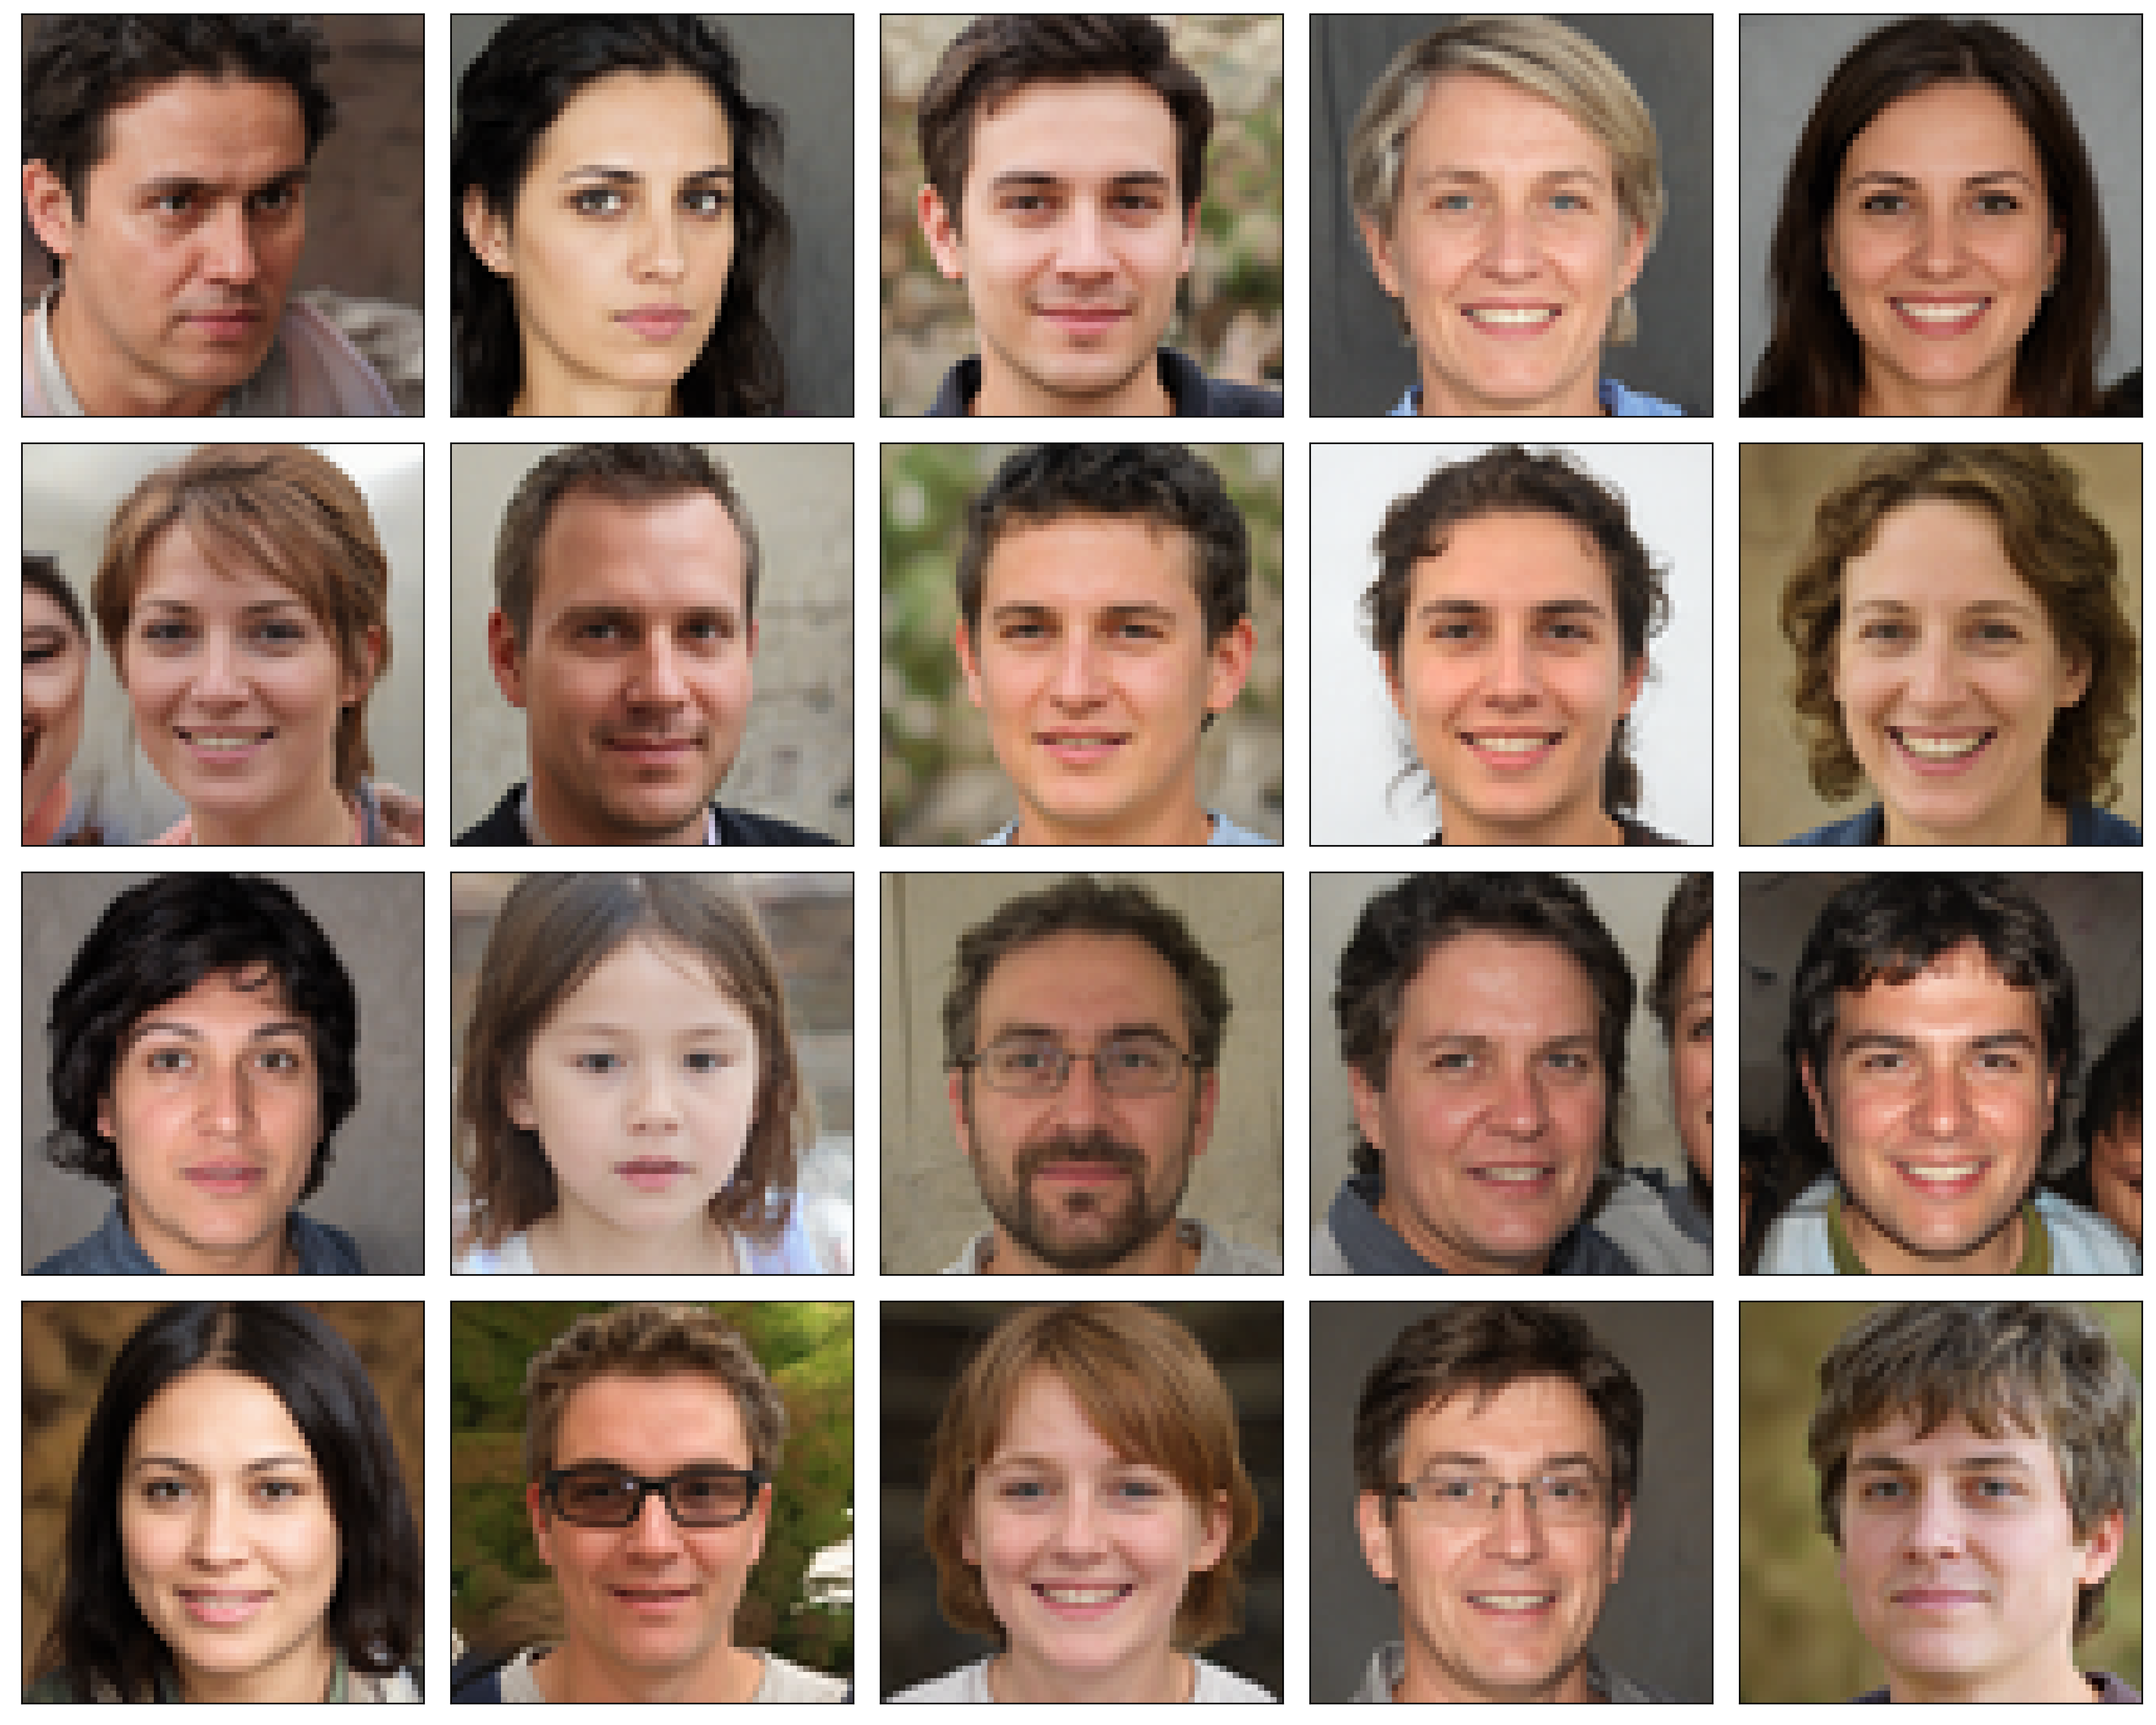

In [13]:
loader = FFHQStyleGAN64DLoader()
data = loader.load_dataset(train=False, dataset_dir="../data/samples/gan64d")
    
fig = plt.figure(figsize=(5*3., 4*3.))

for i in range(20):
    x, _ = data[np.random.randint(len(data) - 1)]
    x_ = np.transpose(np.array(x), [1,2,0]) / 256.
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(x_)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()
